In [1]:
import pandas as pd
import numpy as np
import math
from utils import qualityRMSE, qualityMedianAE, qualityMACAPE
from utils import ExponentialSmoothing as SimpleExponentialSmoothing, AdaptiveExponentialSmoothing # , TheilWageExponentialSmoothing
import matplotlib.pyplot as plt
%matplotlib inline

In [95]:
def AdaptiveSelection(x, h, Params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    Params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        eps <scalar> - bound for best indistinctive models
        BaseAlgs - array of <dict> with params
            BaseAlg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    
    
    BaseAlgs = Params['BaseAlgs']
    N = len(BaseAlgs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
        
    for ba in range(len(BaseAlgs)):
        FORECAST_BA[ba]= eval(BaseAlgs[ba]['BaseAlg']+"(x,h,"+"BaseAlgs["+str(ba)+"]['BaseAlgParams'])")
        
    # internal params of composition
    gamma = Params['gamma']
    eps = Params['eps']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1= np.zeros(N) # initialization of errors of base algorithms
    j_best = np.zeros(N)
    y = np.nan
    
    for t in range(0, T):
        if not math.isnan(x[t]):
            if t>= h:
                temp = np.abs(x[t]-FORECAST_BA.transpose()[t])
                if not np.any(np.isnan(temp)):
                    e1 = gamma*temp+(1-gamma)*e1  
                if not np.all(np.isnan(e1)):
                    j_best = np.nanargmin(e1) 
                    idx_bestinsdistinctive = np.where(e1 < e1[j_best] + eps)[-1]
                    y = FORECAST_BA[idx_bestinsdistinctive,t].mean()
            
            
        FORECAST[t+h] = y
    return FORECAST

In [96]:
def AdaptiveCombination(x, h, Params):
    '''
    Parameters
    x <array> - time series
    h <integer scalar>- forecasting delay
    Params <dict> - dictionary with 
        gamma <scalar in [0,1]> - smoothing parameter of error
        BaseAlgs - array of <dict> with params
            BaseAlg <string> - name of base algorithm
            BaseAlfParams <dict> dictionary of base algorithm's params
    '''
    T = len(x)
    FORECAST = [np.NaN]*(T+h)

    BaseAlgs = Params['BaseAlgs']
    N = len(BaseAlgs)
    FORECAST_BA = np.array([np.NAN]*(T+h)*N).reshape(N, T+h)
    
    
    for ba in range(len(BaseAlgs)):
        FORECAST_BA[ba]= BaseAlgFunctions[BaseAlgs[ba]['BaseAlg']](x,h,BaseAlgs[ba]['BaseAlgParams'])
    
        
    gamma = Params['gamma']
    eps = Params['eps']
    
    if gamma>1:
        w.warn('Gamma can not be more than 1')
        #alpha = 1
        return FORECAST
    if gamma<0:
        w.warn('Gamma can not be less than 0')
        #alpha = 0
        return FORECAST

    
    e1=  np.zeros(N)
    weights =  np.zeros(N)
    y = np.nan
    for t in range(0, T):
        if not np.math.isnan(x[t]):
            
            if t>= h:
                temp = np.abs(x[t]-FORECAST_BA.transpose()[t])
                if not np.any(np.isnan(temp)):
                    e1 = gamma*temp+(1-gamma)*e1  
                if not np.all(np.isnan(e1)):
                    w_best = (1/e1) / np.sum(1/e1)
                    y = np.dot(w_best,FORECAST_BA.T[t])
        FORECAST[t+h] = y
    return FORECAST

In [97]:
BaseAlgFunctions = {
    'SimpleExponentialSmoothing':SimpleExponentialSmoothing,
    'AdaptiveExponentialSmoothing':AdaptiveExponentialSmoothing,
}

In [98]:
BaseAlgs = [{'BaseAlg':'SimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.1, 'AdaptationPeriod':10}},
            {'BaseAlg':'SimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.3, 'AdaptationPeriod':10}},
            {'BaseAlg':'SimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.5, 'AdaptationPeriod':10}},
            {'BaseAlg':'AdaptiveExponentialSmoothing', 'BaseAlgParams':{'alpha':0.2,'gamma':0.02, 'AdaptationPeriod':10}},
            {'BaseAlg':'AdaptiveExponentialSmoothing', 'BaseAlgParams':{'alpha':0.2,'gamma':0.03, 'AdaptationPeriod':10}},
            {'BaseAlg':'AdaptiveExponentialSmoothing', 'BaseAlgParams':{'alpha':0.1,'gamma':0.01, 'AdaptationPeriod':10}},
#                  {'BaseAlg':'AdaptiveSimpleExponentialSmoothing', 'BaseAlgParams':{'alpha':0.1, 'gamma':0.01}},
#                 {'BaseAlg':'TheilWageSmoothing', 'BaseAlgParams':{'alpha':0.3, 'beta':0.9,'delta':0.9}}
]

In [99]:
for ba in range(len(BaseAlgs)):
    print(BaseAlgs[ba]['BaseAlg']+"(x,h,"+"BaseAlgs["+str(ba)+"]['BaseAlgsParams'])")

SimpleExponentialSmoothing(x,h,BaseAlgs[0]['BaseAlgsParams'])
SimpleExponentialSmoothing(x,h,BaseAlgs[1]['BaseAlgsParams'])
SimpleExponentialSmoothing(x,h,BaseAlgs[2]['BaseAlgsParams'])
AdaptiveExponentialSmoothing(x,h,BaseAlgs[3]['BaseAlgsParams'])
AdaptiveExponentialSmoothing(x,h,BaseAlgs[4]['BaseAlgsParams'])
AdaptiveExponentialSmoothing(x,h,BaseAlgs[5]['BaseAlgsParams'])


In [100]:
ts = pd.read_csv('TimeSeries_Data10.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Dates')
ts.index.names=['Timestamp']
ts = ts.sort_index() # sort index

In [101]:
ts[:5]

,Item: 165,Item: 969,Item: 2653,Item: 2654,Item: 2692,Item: 2695,Item: 2697,Item: 2765,Item: 2767,Item: 2806,Item: 2808
Timestamp,,,,,,,,,,,
2005-01-11,NaN,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-12,NaN,5.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-13,NaN,2.0,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-14,NaN,42.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-15,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [102]:
h =1 

FRC_TS = dict()
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+pd.Timedelta(1,'D'), ts.index[-1]+pd.Timedelta(h,'D')))
                      , columns = ts.columns)

In [103]:
# run Adaptive Selection
gamma=0.01
eps = 0.01

for cntr in ts.columns:
    frc_ts[cntr]= AdaptiveSelection(ts[cntr],h, {'gamma':gamma, 'eps': eps, 'BaseAlgs':BaseAlgs})
FRC_TS['AS gamma %.2f eps %.2f' % (gamma, eps)] = frc_ts

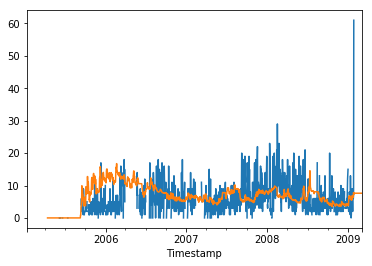

In [104]:
ts['Item: 2697'].plot()
frc_ts['Item: 2765'].plot()

In [105]:
FRC_TS.keys()

dict_keys(['AS gamma 0.01 eps 0.01'])

In [106]:
frc_ts = pd.DataFrame(index = ts.index.append(pd.date_range(ts.index[-1]+pd.Timedelta(1,'D'), ts.index[-1]+pd.Timedelta(h,'D')))
                      , columns = ts.columns)

In [107]:
# run Adaptive Composition
gamma=0.1
eps = 0.01

for cntr in ts.columns:
    frc_ts[cntr]= AdaptiveCombination(ts[cntr],h, {'gamma':gamma,'eps': eps, 'BaseAlgs':BaseAlgs})
FRC_TS['AC gamma %.2f' % (gamma)] = frc_ts

C:\Users\Shahane\Anaconda3\lib\site-packages\ipykernel\__main__.py:48: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\Shahane\Anaconda3\lib\site-packages\ipykernel\__main__.py:48: RuntimeWarning: invalid value encountered in true_divide


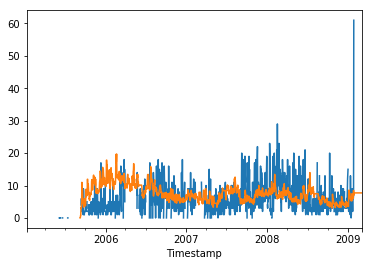

In [108]:
ts['Item: 2697'].plot()
frc_ts['Item: 2765'].plot()

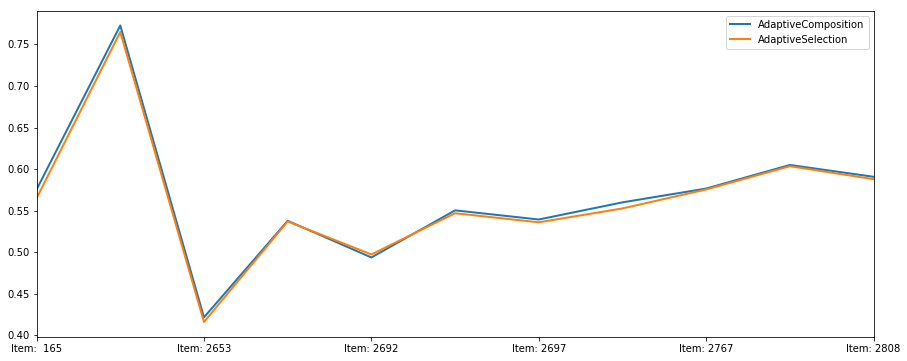

In [109]:
# plot loss of compositions
ix = range(100)
# compare ES methods in first 100 steps
QualityStr = pd.DataFrame(index = ts.columns, columns = sorted(FRC_TS.keys()))

for model in QualityStr.columns:
    frc_ts = FRC_TS[model]
    for ts_num in ts.columns:
        ix = pd.date_range(ts[ts_num].first_valid_index(), ts[ts_num].first_valid_index()+pd.Timedelta(50,'D'))
        QualityStr[model][ts_num],_ = qualityMACAPE(ts[ts_num], frc_ts[ts_num])

plt.figure(figsize=(15,6))
QualityStr[sorted(QualityStr.columns)[0]].plot(label='AdaptiveComposition', linewidth=2.0)
QualityStr[sorted(QualityStr.columns)[1]].plot(label='AdaptiveSelection', linewidth=2.0)

plt.legend()